This notebook focus on Actor-Critc and A2C

In [1]:
import os
# disable tensorflow logging
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import statistics
import numpy as np
import tensorflow as tf
import gym
import tqdm
import collections


2023-03-22 03:22:09.668502: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 03:22:09.748397: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-22 03:22:09.748426: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-22 03:22:10.124208: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
class Env():
    def __init__(self, max_step=1000):
        self.env = gym.make("CartPole-v1")
        self.max_step = max_step
        self.cur_step = 1
        self.action_space = self.env.action_space
        
    def reset(self):
        self.cur_step = 1
        initial_state, info = self.env.reset()
        initial_state = self.add_step_into_state(initial_state)
        return initial_state, info
    
    def add_step_into_state(self, state):
#         state = np.concatenate([state, np.array([self.cur_step/self.max_step])])
        
        return state
    
    def step(self, action):
        self.cur_step += 1
        state, reward, done, _, _ = self.env.step(action)
        if self.cur_step > self.max_step:
            reward = 1.0
            done = True
            self.cur_step = self.max_step + 1
        else:
            if done:
                reward = 1.0
        state = self.add_step_into_state(state)
        return state, reward, done, _, _

In [3]:
env = gym.make("CartPole-v1")
# env = Env()
initial_state, _ = env.reset()
initial_state_shape = initial_state.shape
action_space = env.action_space.n
eps = np.finfo(np.float32).eps.item()
gamma = 0.99
lr = 0.01
step_length = 50


# define model

In [4]:
"""
The model will use basic Actor-Critc (A2C with baseline)
"""

def get_model():
    inputs = tf.keras.layers.Input(shape=initial_state_shape)
    hidden = tf.keras.layers.Dense(128, activation="relu")(inputs)
    actions = tf.keras.layers.Dense(action_space, activation=tf.keras.activations.softmax)(hidden)
    value = tf.keras.layers.Dense(1, activation=None)(hidden)
    outs = [actions, value]
    return tf.keras.Model(inputs, outs)

model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          640         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 2)            258         ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 1)            129         ['dense[0][0]']                  
                                                                                              

2023-03-22 03:22:10.697519: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-22 03:22:10.697714: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-22 03:22:10.697753: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-22 03:22:10.697780: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-22 03:22:10.697806: W tensorflow/c

# define data collection

In [5]:
def run_step(start_state, model, step_length):
    values = []
    actions = []
    action_probs = []
    action_outputs = []
    rewards = []
    state = start_state
    for t in range(step_length):
        action_output, value = model(tf.expand_dims(state, 0))
#         action = tf.random.categorical(tf.math.log(action_output), num_samples=1)[0,0]
        action = np.random.choice(action_space, p=action_output.numpy().squeeze())
        
        state, reward, done, _, _ = env.step(action)
        
        actions.append(action)
        values.append(tf.squeeze(value))
        rewards.append(reward)
        action_probs.append(action_output[0, action])
        if done:
            break
    next_value = 0.0
    if t == step_length - 1:
        vcomplete = 1 / (1 - gamma)
        rewards[-1] = vcomplete
#         vcomplete = tf.constant(vcomplete, dtype=tf.float32)
#         rewards = rewards.write(t, vcomplete)
    rewards = np.array(rewards)
    return values, actions, action_probs, rewards, next_value, state, done

In [6]:
state_, _ = env.reset()
result = run_step(state_, model, 100)
values, actions, action_probs, rewards, next_state, state, done = result

/home/wei/anaconda3/envs/tf_211/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [7]:
result

([<tf.Tensor: shape=(), dtype=float32, numpy=0.0149457>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.060648415>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.010348349>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.055135168>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.111847736>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.16812392>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.10329543>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.16129808>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.09775437>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.15620917>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.09482085>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.03711483>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.0961011>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.039238513>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.004254672>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.044335134>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.0052506872>,
  <tf.T

# define returns

In [8]:
def get_returns(rewards_array, gamma=0.99):
    """
    Input: total_rewards is a value
    Output: 
        discount_array: array of discount rate.
            index i to the (end timestamp + 1) discount rate
        returns: array of discounted returns
            index i means the returns between index i to the index(end timestamp + 1)
    """
    discounted_return = 0.0
    returns = []
    for idx in range(len(rewards_array)-1,  -1, -1):
        discounted_return = gamma * discounted_return + rewards_array[idx]
        returns.append(discounted_return)
    returns = returns[::-1]
    discount_array = np.ones_like(rewards_array) * gamma
    discount_array = np.cumprod(discount_array)
    discount_array = discount_array[::-1]
    returns = np.array(returns)
    returns = (returns - returns.mean()) / (eps + returns.std())
    return discount_array, returns

In [9]:
rewards = result[3]
get_returns(rewards)

(array([0.62352539, 0.62982363, 0.63618549, 0.6426116 , 0.64910263,
        0.65565922, 0.66228204, 0.66897176, 0.67572905, 0.6825546 ,
        0.68944909, 0.69641322, 0.70344769, 0.71055323, 0.71773053,
        0.72498034, 0.73230337, 0.73970037, 0.74717209, 0.75471929,
        0.76234271, 0.77004315, 0.77782136, 0.78567814, 0.79361428,
        0.80163059, 0.80972787, 0.81790694, 0.82616862, 0.83451376,
        0.84294319, 0.85145777, 0.86005835, 0.86874581, 0.87752102,
        0.88638487, 0.89533825, 0.90438208, 0.91351725, 0.92274469,
        0.93206535, 0.94148015, 0.95099005, 0.96059601, 0.970299  ,
        0.9801    , 0.99      ]),
 array([ 1.57053745,  1.51217098,  1.45321496,  1.39366342,  1.33351035,
         1.27274967,  1.21137525,  1.14938088,  1.08676031,  1.02350721,
         0.95961519,  0.89507779,  0.8298885 ,  0.76404074,  0.69752784,
         0.6303431 ,  0.56247972,  0.49393086,  0.42468958,  0.35474889,
         0.28410174,  0.21274097,  0.14065939,  0.06784971, -0

# Loss

In [10]:
loss_func = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
def calculate_loss(returns, values, action_probs, value_next, discount_array):
    """
    Policy part ---------
    V(St) = E(Q) = Pi(St, At1; theta) * Q(St, At1) + ...
    G denote gradient W.R.T theta
    
    
    G(V(St)) = G[Pi(St, At1; theta) * Q(St, At1) + ...]
                approximate= Pi(St, A1)* G(logpi(St, At1; theta) * Q) + ...  # chain rule G(logpi) = 1/pi * G(pi)
                = E[ G(logpi * Q) ] # Pi(St, A) is the PDF, so this is the expectation
              [1]  approximate= G(logpi * Q)  # monte carlo approximation
              [2]  = G(logpi * (Q - baseline))  where baseline can be V. This is the A2C
                  Qt can be approximate by Yt
              Yt = gamma^T * Q(T) + r + gamma*r + gamma^2*r + ...
              
    Critic Part TD learning -----------
    Qt = discounted_ovserved + QT
            
    """
    action_probs = tf.stack(action_probs)
    logpi = tf.math.log( tf.clip_by_value(action_probs, eps, 1.0))
    values = tf.stack(values)
    Yt = tf.convert_to_tensor(returns, dtype=tf.float32)

    
    # this is the negative gradient instead of loss
    loss_actor = - logpi * (Yt - values)
    loss_actor = tf.reduce_mean(loss_actor)
    # critic
    loss_critic = loss_func(tf.expand_dims(Yt, 1), tf.expand_dims(values,1))
    loss = loss_actor + loss_critic
    return loss, loss_actor, loss_critic#, abs(Yt - values)

In [11]:
values, actions, action_probs, rewards, next_value, state, done = result
discount_array, returns_array = get_returns(rewards, gamma)
calculate_loss(returns_array, values, action_probs, next_value, discount_array)

(<tf.Tensor: shape=(), dtype=float32, numpy=1.0402046>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.069316864>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.1095215>)

# train step

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# @tf.function
def run_train_step(model, optimizer, start_state, step_length):
    with tf.GradientTape() as tape:
        STEP_RES = run_step(start_state, model, step_length)
        values, actions, action_probs, rewards, next_value, state, done = STEP_RES
        discount_array, returns_array = get_returns(rewards, gamma)
        loss, loss_actor, loss_critic = calculate_loss(returns_array, values, action_probs, next_value, discount_array)
    gradient = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradient, model.trainable_variables))
    return STEP_RES, loss, loss_actor, loss_critic

In [13]:
_state, _ = env.reset()
run_train_step(model, optimizer, _state, 50)

(([<tf.Tensor: shape=(), dtype=float32, numpy=0.0023317777>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.052404646>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.10836847>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.052286964>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.0037440395>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.061133504>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.119796656>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.056359984>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.11552256>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.17337242>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.23047182>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.28699428>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.22237761>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.28010964>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.3377324>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.276584>,
   <tf.Tensor: shape=(), dtype=float32, numpy=0.33

# RUN

In [14]:
min_epoch = 100
max_epoch = 10000
step_length = 500
thred = 475
running_rewards = collections.deque(maxlen=100)
max_steps_per_epoch = 500
all_rewards = []
all_running_rewards = []
t = tqdm.trange(max_epoch)
for i in t:
    start_state, _ = env.reset()
    cur_step = 0
    epoch_reward = 0
    while cur_step < max_steps_per_epoch:
        STEP_RES, loss, loss_actor, loss_critic = run_train_step(model, optimizer, start_state, step_length)
        cur_step += step_length
        values, actions, action_probs, rewards, next_value, state, done = STEP_RES
        epoch_reward += int(sum(rewards))
        values.clear()
        actions.clear()
        action_probs.clear()
        if done:
            break
    running_rewards.append(epoch_reward)
    avg_reward = statistics.mean(running_rewards)
    all_rewards.append(epoch_reward)
    all_running_rewards.append(avg_reward)
    t.set_postfix(running_rewards=avg_reward, current_reward=epoch_reward, loss=float(loss))
    if avg_reward > thred and i > min_epoch:
        break
    
    


  3%|▎         | 294/10000 [01:36<53:09,  3.04it/s, current_reward=598, loss=-.0559, running_rewards=477]   


In [16]:
##
"""
no normalization
(1) 663/10000 [02:34<36:16,  4.29it/s, current_reward=1000, loss=409, running_rewards=482]  
(2) 491/10000 [03:25<1:06:16,  2.39it/s, current_reward=392, loss=916, running_rewards=476] 
(3) 511/10000 [03:54<1:12:42,  2.18it/s, current_reward=1000, loss=745, running_rewards=479]
(4) 658/10000 [04:02<57:26,  2.71it/s, current_reward=1000, loss=634, running_rewards=480]

with normalization
SUM
(1) 7%|▋         | 679/10000 [05:48<1:19:49,  1.95it/s, current_reward=500, loss=488, running_rewards=476]   

MEAN
(1) 519/10000 [04:35<1:23:46,  1.89it/s, current_reward=500, loss=0.655, running_rewards=476]  
(2) 4%|▍         | 390/10000 [03:22<1:23:05,  1.93it/s, current_reward=405, loss=0.0921, running_rewards=476] 
(3) 5%|▌         | 513/10000 [04:25<1:21:57,  1.93it/s, current_reward=500, loss=1.05, running_rewards=477]   


MEAN + modify last rewards
(1) 2%|▏         | 226/10000 [01:36<1:09:17,  2.35it/s, current_reward=598, loss=-.0738, running_rewards=475] 
(2) 3%|▎         | 294/10000 [01:36<53:09,  3.04it/s, current_reward=598, loss=-.0559, running_rewards=477]   
"""

# old env


'\nno normalization\n(1) 663/10000 [02:34<36:16,  4.29it/s, current_reward=1000, loss=409, running_rewards=482]  \n(2) 491/10000 [03:25<1:06:16,  2.39it/s, current_reward=392, loss=916, running_rewards=476] \n(3) 511/10000 [03:54<1:12:42,  2.18it/s, current_reward=1000, loss=745, running_rewards=479]\n(4) 658/10000 [04:02<57:26,  2.71it/s, current_reward=1000, loss=634, running_rewards=480]\n\nwith normalization\nSUM\n(1) 7%|▋         | 679/10000 [05:48<1:19:49,  1.95it/s, current_reward=500, loss=488, running_rewards=476]   \n\nMEAN\n(1) 519/10000 [04:35<1:23:46,  1.89it/s, current_reward=500, loss=0.655, running_rewards=476]  \n(2) 4%|▍         | 390/10000 [03:22<1:23:05,  1.93it/s, current_reward=405, loss=0.0921, running_rewards=476] \n(3) 5%|▌         | 513/10000 [04:25<1:21:57,  1.93it/s, current_reward=500, loss=1.05, running_rewards=477]   \n\n\nMEAN + modify last rewards\n(1) 2%|▏         | 226/10000 [01:36<1:09:17,  2.35it/s, current_reward=598, loss=-.0738, running_rewards=4

In [17]:
from matplotlib import pyplot as plt

In [18]:
_state, _ = env.reset()
result = run_step(_state, model, 1000)
values, actions, action_probs, rewards, next_value, state, done = result

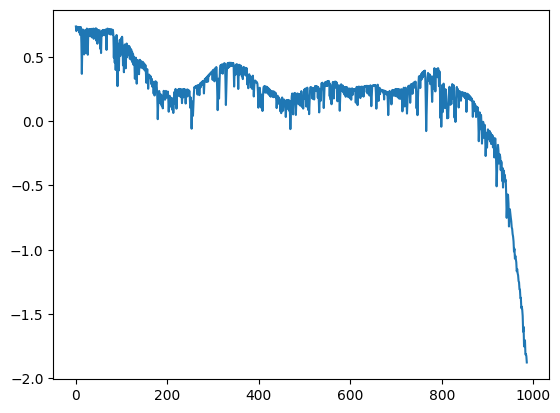

In [19]:
plt.plot(range(len(values)), values)

In [20]:
action_probs

[<tf.Tensor: shape=(), dtype=float32, numpy=0.60322905>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.5566519>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.3981096>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.70053697>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.61205125>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.5262169>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.38775152>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.71900743>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.376194>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.7387227>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.638013>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.541682>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.27969155>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.93160456>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.7754051>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.47789308>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.80750495>,
 <tf.Tensor: shape=(), dtype=float32, nump

In [19]:
9.62213000   * 2841

27336.47133